In [1]:
import skorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable

In [2]:
from sine_data import train_dataset, valid_dataset

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import insp

In [4]:
import visdom
vis = visdom.Visdom()

In [5]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [6]:
class InhCWRNN(nn.Module):
    def __init__(self, input_dim, output_dim, num_modules, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_modules = num_modules
        
        self.input_mod = nn.Linear(input_dim, output_dim)
        self.hidden_mod = nn.Linear(output_dim, output_dim, bias=False)
        
        #self.module_periods = nn.Parameter(torch.zeros(output_dim) + 1)
        #self.module_shifts = nn.Parameter(torch.zeros(output_dim))
        self.module_periods = nn.Parameter(torch.zeros(num_modules) + 1)
        self.module_shifts = nn.Parameter(torch.zeros(num_modules))
        
        self.f_mod = nn.Tanh()        
        
    def step(self, ti, xi, h):
        module_size = self.output_dim // self.num_modules
        
        acts = self.f_mod(self.input_mod(xi) + self.hidden_mod(h))
        module_acts = acts.view(-1, self.num_modules, module_size)
                
        # y=(sin(x)+1)/2 so we y is in [0;1]
        gate = (torch.sin(ti * self.module_periods + self.module_shifts) + 1) / 2
        gate = gate.view(1, -1, 1).expand_as(module_acts).contiguous()
        gate = gate.view(-1, self.output_dim)
                
        y = (1 - gate) * acts + gate * h
        
        return y, y
        
    def init_hidden(self):
        return Variable(torch.zeros(self.output_dim))
        
    def forward(self, x):
        t = x.size(1)
        ys = []
        h = self.init_hidden()
        for ti in range(t):
            xi = x[:, ti]
            yi, h = self.step(ti, xi, h)            
            ys.append(yi)
        return torch.stack(ys, dim=1), h

In [7]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [8]:
class ReconModel(nn.Module):
    def __init__(self, num_hidden=64, num_modules=8):
        super().__init__()
        
        self.rnn = InhCWRNN(1, num_hidden, num_modules)
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        l0, h0 = self.rnn(x)
        
        vis.heatmap(l0[0].data.numpy(), win="act")
        vis.heatmap(self.rnn.module_periods.data.numpy().reshape(1, -1), win="periods")
        vis.heatmap(self.rnn.module_shifts.data.numpy().reshape(1, -1), win="shifts")

        l1 = self.clf(time_flatten(l0))
        return time_unflatten(l1, x.size())

In [9]:
class Trainer(skorch.NeuralNet):
    def __init__(self, 
                 criterion=nn.MSELoss,
                 *args, 
                 **kwargs):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)

### exp inhibition

In [10]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_relu = Trainer(module=ReconModel,
             optimizer=torch.optim.Adam,
             lr=0.005,
             max_epochs=30,
             train_split=my_train_split,
             
             module__num_modules=8,
             module__num_hidden=64,
            )

In [11]:
%pdb on
ef_relu.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.8103        0.8194  0.3408
      2        0.8136        0.4002  0.3730
      3        0.3800        0.2663  0.3460
      4        0.2522        0.1979  0.3747
      5        0.2013        0.1224  0.3315
      6        0.1416        0.0812  0.3699
      7        0.1061        0.0981  0.3322
      8        0.1196        0.1260  0.3456
      9        0.1426        0.1162  0.3791
     10        0.1307        0.0742  0.3485
     11        0.0887        0.0338  0.3767
     12        0.0486        0.0186  0.2885
     13        0.0324        0.0274  0.3853
     14        0.0391        0.0434  0.3434
     15        0.0524        0.0514  0.3688
     16        0.0582        0.0483  0.3842
     17        0.0537        0.0404  0.3444
     18        0.0452        0.0351  0.3809
     19        0.0399        0.0347  0.3356
     20        0.0398        0.0362

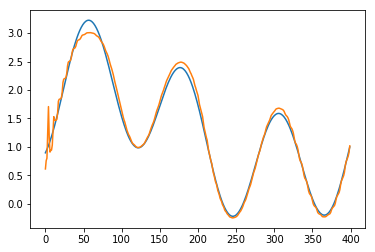

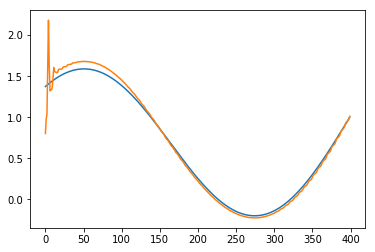

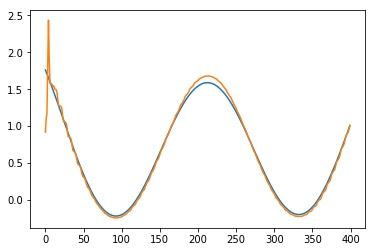

In [12]:
data = X_valid
pred = ef_relu.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])